# Enhancement Prototype

This notebook prototypes the prediction of the wind power using a supervised machine learning model that is trained on historical data. First we import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

We read in the dataset that was generated in the `EDA_ETL.ipynb` notebook.

In [2]:
data = pd.read_csv("sample_data.csv", index_col=0)

We transform the raw data in the training and test data in standard Scikit-Learn format.

In [3]:
X = data[[col for col in data.columns if "turb" in col]]
y = data["Wind"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, shuffle=False)

We train a Ridge-Regression linear model, that utilizes the best 200 features (wind speeds or temperatures at turbine locations) with a second degree polynomial feature generation. We perform hyperparameter tuning using the grid-search cross validator.

In [4]:
param_grid = {"ridge__alpha": np.logspace(2,3,20)}

pipe = Pipeline([("ridge", Ridge(random_state=0))])

gs = GridSearchCV(pipe, param_grid=param_grid, cv=KFold(n_splits=3), verbose=0, return_train_score=True)

model = Pipeline([("ss", StandardScaler()),
                  ("skb", SelectKBest(mutual_info_regression, k=200)),
                  ("pf", PolynomialFeatures(degree=2)),
                  ("gs", gs)])

model.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('skb',
                 SelectKBest(k=200,
                             score_func=<function mutual_info_regression at 0x7ff469ea5820>)),
                ('pf', PolynomialFeatures()),
                ('gs',
                 GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                              estimator=Pipeline(steps=[('ridge',
                                                         Ridge(random_state=0))]),
                              param_grid={'ridge__alpha': array([ 100.        ,  112.88378917,  127.42749857,  143.84498883,
        162.37767392,  183.29807108,  206.91380811,  233.57214691,
        263.66508987,  297.63514416,  335.98182863,  379.26901907,
        428.13323987,  483.29302386,  545.55947812,  615.84821107,
        695.19279618,  784.75997035,  885.86679041, 1000.        ])},
                              return_train_score=True))])

We plot the historic power data that the model was trained on in addition to the predictions of the test holdout portion of the dataset. The very high R2 score demonstrates that there is a strong correlation between the weather forecasts and the power generation, which validates the whole methodology that we are pursuing. This model would suffice for most prediction applications, but we may try to train a more complex model to increase the prediction power.

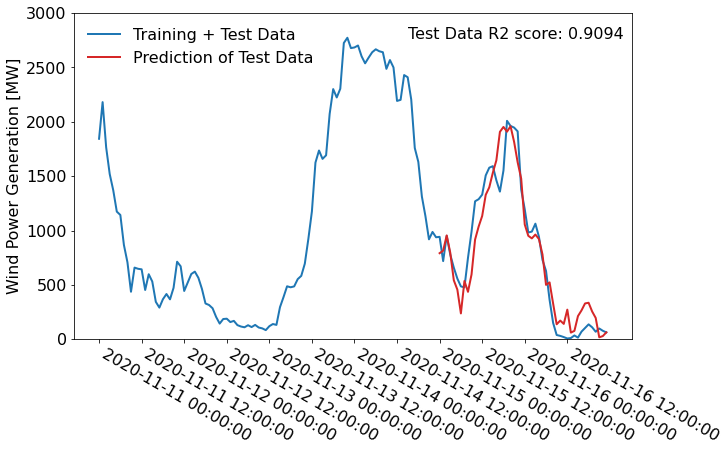

In [150]:
fig = plt.figure(figsize=(10,6))
plt.plot(X.index, y, label="Training + Test Data", lw=2, color="tab:blue")
plt.plot(X_test.index, model.predict(X_test), label="Prediction of Test Data", lw=2, color="tab:red")
plt.xticks(data.index[::12], fontsize=16, rotation=-30, ha="left")
plt.yticks(fontsize=16)
plt.legend(frameon=False, fontsize=16)
plt.ylabel("Wind Power Generation [MW]", fontsize=16)
plt.ylim(0, 3000)
plt.annotate("Test Data R2 score: {:.04f}".format(model.score(X_test, y_test)), [0.6, 0.92], fontsize=16, xycoords="axes fraction");

Another possible modeling method is to fit a Kernel Density Estimate to the joint distribution of average wind speed and power generation. The KDE will then be used to get a confidence interval for the power level using the forecasted weather data. First we fit the KDE to the training data.

In [78]:
from scipy.stats import gaussian_kde

X_vel_avg = X[[col for col in X.columns if "vel" in col]].mean(axis=1).to_numpy()
X_vel_avg_train, X_vel_avg_test, y_train, y_test = train_test_split(X_vel_avg, y, test_size=1/3, shuffle=False)

X_kde = np.vstack((X_vel_avg_train, y_train))

KDE = gaussian_kde(X_kde)

We visualize the KDE's PDF with the training data.

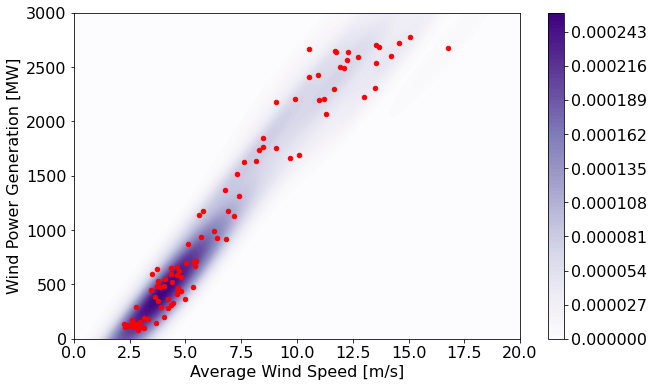

In [151]:
plt.figure(figsize=(10,6))
gridx, gridy = np.meshgrid(np.linspace(0, 20, 100), np.linspace(0, 3000, 100))
grid = np.vstack((gridx.ravel(), gridy.ravel()))
plt.contourf(gridx, gridy, KDE(grid).reshape(gridx.shape), levels=100, cmap="Purples")
plt.colorbar().ax.tick_params(labelsize=16) 
plt.scatter(X_kde[0,:], X_kde[1,:], color="red", s=20, label="Training Data")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Average Wind Speed [m/s]", fontsize=16)
plt.ylabel("Wind Power Generation [MW]", fontsize=16);

We write a function to take the KDE and compute a C.I. for the power generation at a specific average wind speed.

In [132]:
def cond_ci(KDE, w, p_max, level=0.01):
    ps = np.linspace(0, p_max, 1000)
    cdf_cond = np.cumsum([KDE([w, p])[0] for p in ps])
    cdf_cond -= cdf_cond[0]
    cdf_cond /= cdf_cond[-1]
    low = ps[np.argmin(np.abs(cdf_cond - level / 2.))]
    upp = ps[np.argmin(np.abs(cdf_cond - 1 + level / 2.))]
    return low, upp

Then we compute a confidence band for the predicted power generation during the test portion of the data. This model has the benefit of presenting the level of uncertainty in the prediction.

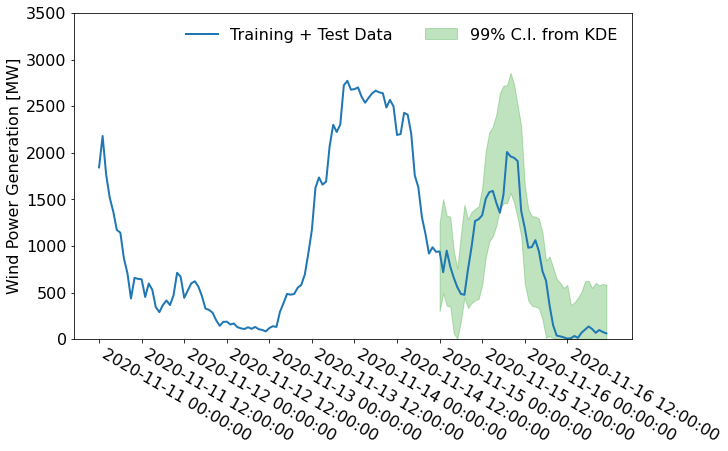

In [145]:
plt.figure(figsize=(10,6))
plt.plot(X.index, y, label="Training + Test Data", lw=2)
low_arr = []
upp_arr = []
for w in X_vel_avg_test:
    low, upp = cond_ci(KDE, w, 2*np.amax(y_train))
    low_arr.append(low)
    upp_arr.append(upp)
plt.fill_between(X_test.index, low_arr, upp_arr, alpha=0.3, color="tab:green",
                 label="99% C.I. from KDE")
plt.xticks(data.index[::12], fontsize=16, rotation=-30, ha="left");
plt.yticks(fontsize=16)
plt.legend(frameon=False, fontsize=16, ncol=2)
plt.ylabel("Wind Power Generation [MW]", fontsize=16)
plt.ylim(0, 3500);